# Dependencies and Libraries

In [ ]:
!pip install -q kaggle
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
# Data Prep
import keras,os
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Colab library to upload files to notebook
from google.colab import files

from IPython.display import clear_output
import os
import platform
import pandas as pd
import random as python_random
import matplotlib.pyplot as plt

In [ ]:
### TPU Check
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.5.0


# Data Input

In [ ]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset from upstream
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

100% 3.24G/3.24G [00:36<00:00, 86.9MB/s]
100% 3.24G/3.24G [00:36<00:00, 94.7MB/s]


In [ ]:
!ls

a-large-scale-fish-dataset.zip	kaggle.json  sample_data


In [ ]:
# Unzip dataset into a folder
!unzip a-large-scale-fish-dataset.zip -d tmp

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00435.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00436.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00437.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00438.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00439.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00440.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00441.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00442.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00443.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00444.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00445.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00446.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00447.png  
  inflating: tmp/Fish_Dataset/Fish_Dataset/S

In [ ]:
MyDrive = '/content/tmp'
clear_output()

DataDir = '/content/tmp/Fish_Dataset/Fish_Dataset'
os.listdir(DataDir)

['README.txt',
 'Shrimp',
 'Black Sea Sprat',
 'license.txt',
 'Gilt-Head Bream',
 'Red Sea Bream',
 'Red Mullet',
 'Sea Bass',
 'Trout',
 'Hourse Mackerel',
 'Segmentation_example_script.m',
 'Striped Red Mullet']

# Data Preparation and Augmentation

In [ ]:
import cv2
import time
import imageio
import imgaug.augmenters as iaa
import imgaug as ia
from tqdm import tqdm
ia.seed(73)

IMG_SIZE = 224
ColorCh = 3

CATEGORIES = []
for list_ in os.listdir(DataDir):
    if not '.' in list_:
        CATEGORIES.append(list_)

print(CATEGORIES)

['Shrimp', 'Black Sea Sprat', 'Gilt-Head Bream', 'Red Sea Bream', 'Red Mullet', 'Sea Bass', 'Trout', 'Hourse Mackerel', 'Striped Red Mullet']


In [ ]:
def isValid(text):
    supported_types = ['.png', '.jpg', '.jpeg']
    for img_type in supported_types:
        if img_type in text:
            return True
        else:
            return False

import random
random.seed(73)

def prepareData(Dir, split_ratio):
    X = []
    y = []
    Frame = []
    
    flip = iaa.Fliplr(1.0)
    zoom = iaa.Affine(scale=1)
    random_brightness = iaa.Multiply((1, 1.2))
    rotate = iaa.Affine(rotate=(-20, 20))
    
    for i, category in enumerate(CATEGORIES):
        path = os.path.join(Dir, category, (category))        
        if not os.path.isdir(path):
            pass
        
        else:
            class_num = CATEGORIES.index(category)
            limit = 500 # images from each class
            img_list = os.listdir(path)[0:limit]
            random.shuffle(img_list)
            
            for img in tqdm(img_list):
                if isValid(img):
                    orig_img = cv2.imread(os.path.join(path,img) , cv2.IMREAD_COLOR)
                    image_aug = cv2.resize(orig_img, (IMG_SIZE, IMG_SIZE), 
                                           interpolation = cv2.INTER_CUBIC)
                    
                    image_aug = flip(image = image_aug)
                    image_aug = random_brightness(image = image_aug)
                    image_aug = zoom(image = image_aug)
                    image_aug = rotate(image = image_aug)
                    
                    image_aug = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                    X.append(image_aug)
                    y.append(class_num)
                else:
                    pass
 
    if len(X) > 0:
        train_len = int(len(X) * split_ratio)
        
        features = pd.DataFrame((np.array(X)).reshape(-1, IMG_SIZE * IMG_SIZE * ColorCh))
        labels = pd.DataFrame({'label': y})
        
        Frame = pd.concat([features, labels], axis=1).sample(frac = 1, random_state=73)     
        train_df, test_df = Frame[train_len:], Frame[:train_len]
        
        return train_df, test_df

In [ ]:
train_df, test_df = prepareData(DataDir, split_ratio=0.2)

100%|██████████| 500/500 [00:08<00:00, 60.20it/s]


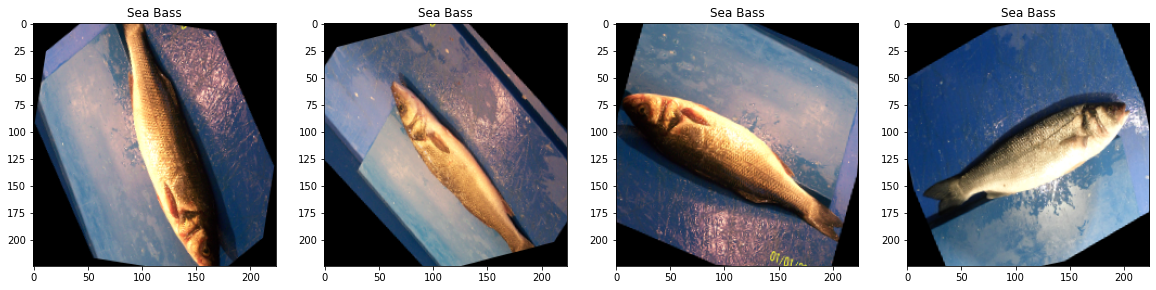

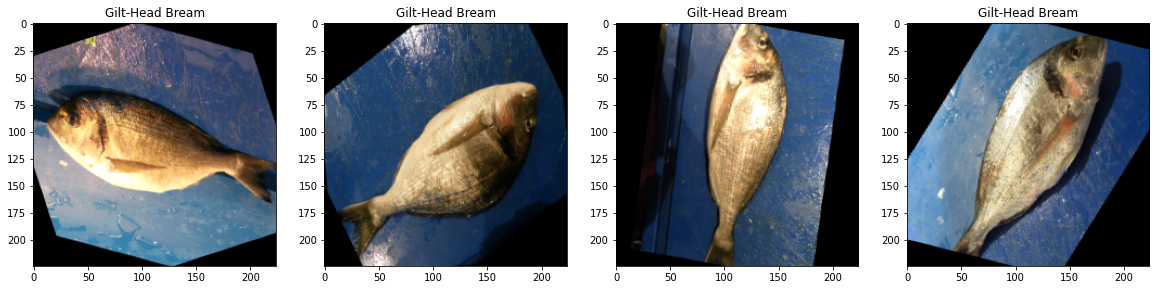

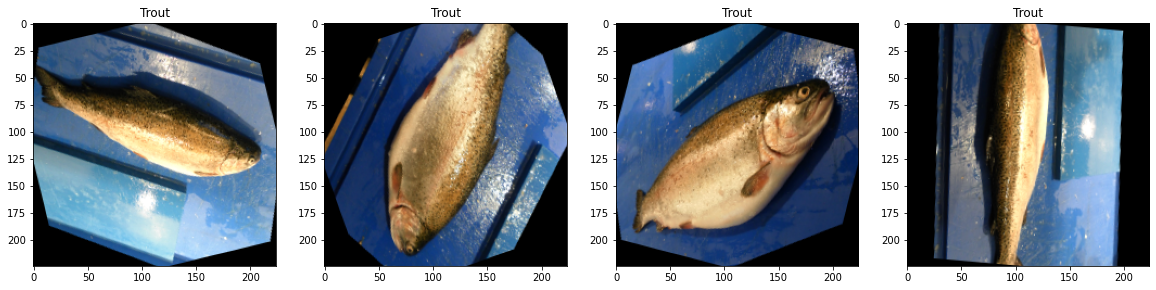

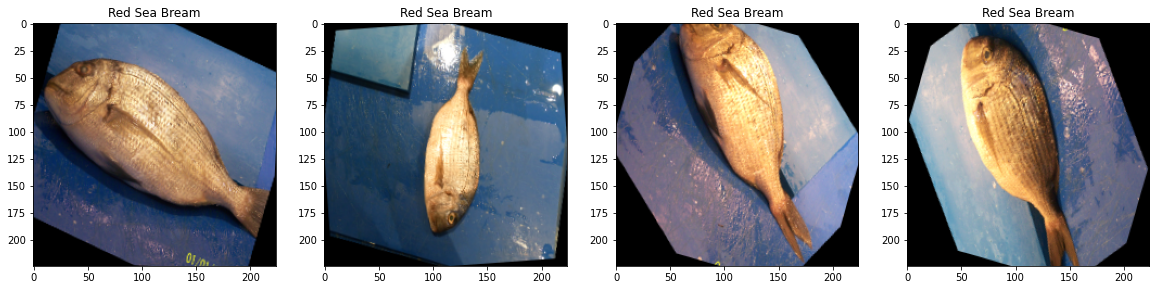

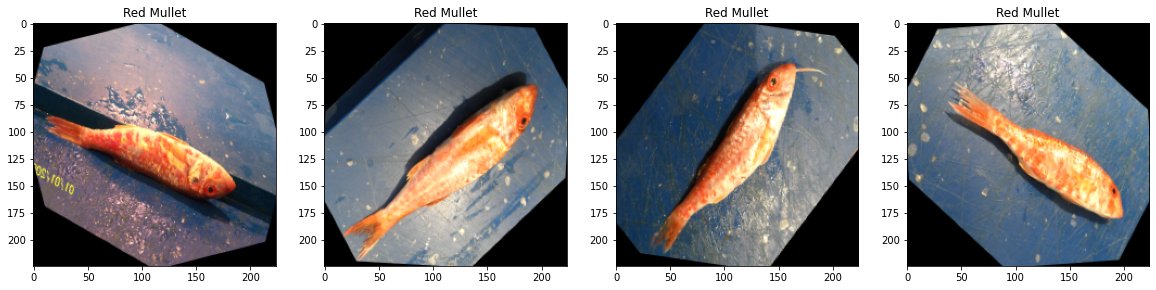

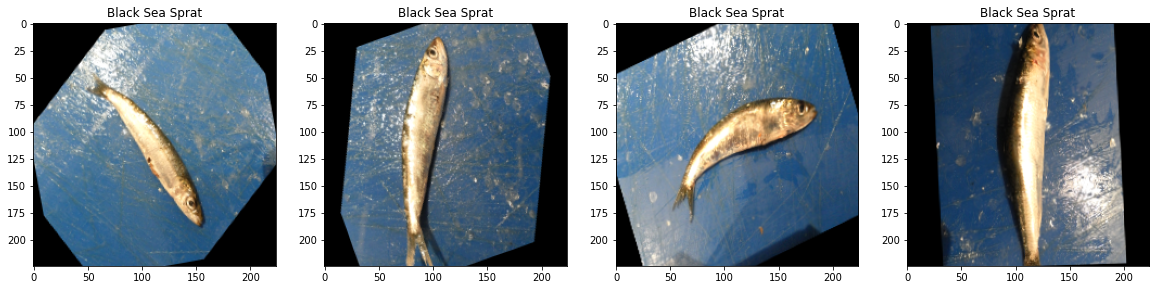

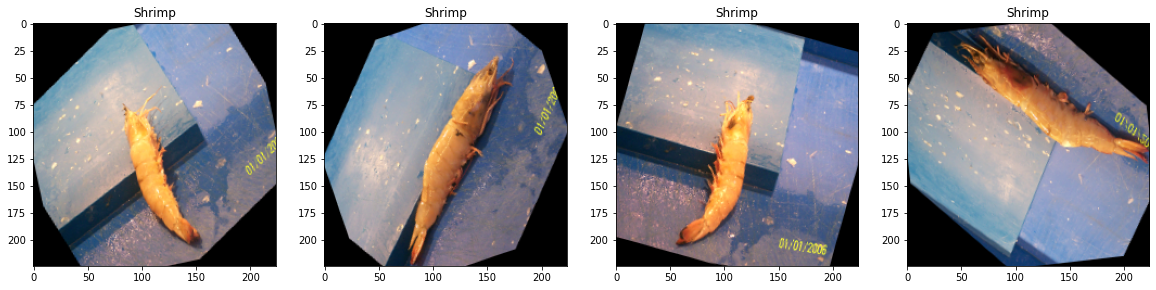

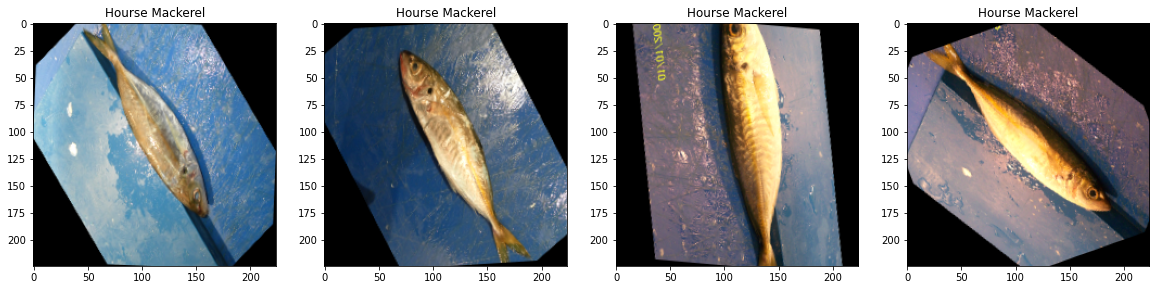

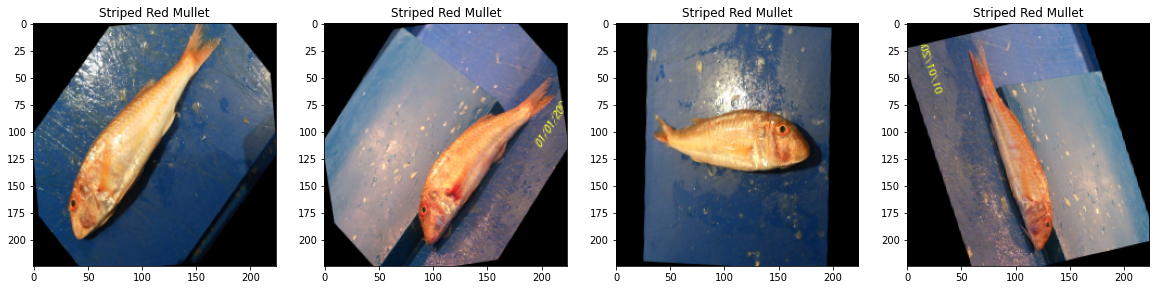

In [ ]:
import matplotlib.pyplot as plt

def print_images(samples):
    images = samples.drop(["label"],axis = 1).to_numpy()
    labels = samples['label'].to_numpy()
    
    fig=plt.figure(figsize=(20, 8))
    columns = 4
    rows = 1
    
    for i, image in enumerate(images):
        fig.add_subplot(rows,columns,i + 1)
        title = '{}'.format(CATEGORIES[labels[i]])
        Sample_image = image.reshape(IMG_SIZE, IMG_SIZE, ColorCh)
        plt.imshow(Sample_image, cmap='gray')
        plt.title(title)
        
    plt.show()
        
label_count = pd.Series(test_df['label'].values.ravel()).value_counts()
for label in list(label_count.index.values):
    samples = (test_df[test_df['label']==int(label)].iloc[0:4])
    print_images(samples)

%matplotlib inline

In [ ]:
print('> DataFrame shape: ',train_df.shape)
print('> {} image data '.format(train_df.shape[0]))
print('> {} --> ({} * {} * {}) pixels + 1 label for each image (1d scaled)\n'.format(train_df.shape[1], IMG_SIZE,IMG_SIZE, ColorCh))

label_count_train = pd.Series(train_df['label'].values.ravel()).value_counts()
n_classes = len(label_count_train)
print('> Total Classes: {}'.format(n_classes))

> DataFrame shape:  (3600, 150529)
> 3600 image data 
> 150529 --> (224 * 224 * 3) pixels + 1 label for each image (1d scaled)

> Total Classes: 9


In [ ]:
print('> label count for train')
for i in range(len(label_count_train)):
    print('> {} : {}'.format(CATEGORIES[i], label_count_train[i]))

> label count for train
> Shrimp : 405
> Black Sea Sprat : 405
> Gilt-Head Bream : 390
> Red Sea Bream : 397
> Red Mullet : 399
> Sea Bass : 390
> Trout : 396
> Hourse Mackerel : 406
> Striped Red Mullet : 412


In [ ]:
X_train = train_df.drop(["label"],axis = 1).to_numpy().reshape(-1,IMG_SIZE,IMG_SIZE,ColorCh).astype(np.float32) / 255.0
y_train = train_df['label']

X_test = test_df.drop(["label"],axis = 1).to_numpy().reshape(-1,IMG_SIZE,IMG_SIZE,ColorCh).astype(np.float32) / 255.0
y_test = test_df['label']

In [ ]:
# data summary
print('> {} train images'.format(X_train.shape[0]))
print('> {} test images'.format(X_test.shape[0]))

input_shape = X_train.shape[1:]
print('> input shape:', input_shape)

> 3600 train images
> 900 test images
> input shape: (224, 224, 3)


# Model

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import activations
from keras import regularizers

In [ ]:
model = tf.keras.models.Sequential([
    # input shape: (224, 224, 3)
    # This is the first convolution
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),

    # The second convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(units=n_classes, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

model.summary()

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard, EarlyStopping

# Load the TensorBoard notebook extension
#%load_ext tensorboard

import datetime
log_dir = "logs/fit/"+ '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                   histogram_freq=1)
# Clear any logs from previous runs
#!rm -rf ./logs/

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999) | (logs.get('loss') <= 0.01)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True
            
end_callback = myCallback()

checkpoints = ModelCheckpoint("model_weight.h5", 
                               monitor='val_accuracy', 
                               verbose=1, 
                               save_best_only=True, 
                               save_weights_only=False, 
                               mode='auto', 
                               period=1)

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               min_delta=0, 
                               patience=10, 
                               verbose=1, 
                               mode='auto',
                               restore_best_weights=True,)

callbacks= [end_callback, tensorboard_callback, early_stopping, checkpoints]

#start=time()

EPOCHS = 5
batch_size = 32

history = model.fit(X_train,y_train,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    batch_size = batch_size,
                    validation_data = (X_test, y_test)
                    )

print("Model training time = "+str(time()-start))

Epoch 1/5
225/225 [==============================] - 587s 3s/step - loss: 1.6263 - accuracy: 0.3839 - val_loss: 0.9368 - val_accuracy: 0.6800
Epoch 2/5
225/225 [==============================] - 576s 3s/step - loss: 0.8579 - accuracy: 0.6956 - val_loss: 0.9291 - val_accuracy: 0.6756
Epoch 3/5
225/225 [==============================] - 576s 3s/step - loss: 0.5825 - accuracy: 0.7933 - val_loss: 0.4438 - val_accuracy: 0.8544
Epoch 4/5
225/225 [==============================] - 563s 3s/step - loss: 0.4022 - accuracy: 0.8572 - val_loss: 0.4953 - val_accuracy: 0.8144
Epoch 5/5
225/225 [==============================] - 571s 3s/step - loss: 0.3278 - accuracy: 0.8825 - val_loss: 0.3012 - val_accuracy: 0.8933


In [ ]:
model.save('IPAN_model.h5')

In [ ]:
#%tensorboard --logdir logs/fit